In [1]:
import flopy as fp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys

flopy is installed in C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\flopy


In [2]:
workspace = "workspace"
model_name = "test_mf6_pst"
exe_name="../../exe/mf6.exe"

nrow = 10
ncol = 10

In [3]:
def model_run(k):
    
    # spatial param
    nlay = 1
    delc = 10
    delr = 10
    top = 10
    botm = 0

    # packages
    sim = fp.mf6.MFSimulation(sim_name=model_name, version='mf6', exe_name=exe_name, 
                                 sim_ws=workspace)
    tdis = fp.mf6.ModflowTdis(sim, pname='tdis', time_units='SECONDS', 
                                 nper=1, perioddata=[(1.0, 1, 1.0)])
    gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                               model_nam_file='{}.nam'.format(model_name))
    dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,top=top, botm=botm)
    ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity="simple")
    ic   = fp.mf6.ModflowGwfic(gwf,strt=botm+1)

    oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                                head_filerecord='{}.hds'.format(model_name),
                                saverecord=[('HEAD', 'LAST'),
                                            ('BUDGET', 'LAST')],
                                printrecord=[('HEAD', 'ALL')])
    

    npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=k,save_flows=True)
    
    #bc
    chd = []
    for irow in range(nrow):
        chd.append(((0,irow,0),10))
        chd.append(((0,irow,ncol-1),0))
    chd = fp.mf6.ModflowGwfchd(gwf,pname="chd",filename="bc.chd",maxbound=len(chd),stress_period_data=chd,save_flows=True)
    
    
    
    lst_pts = []
    for irow in range(1,nrow-1):
        for icol in range(1,ncol-1):
            lst_pts.append((0,irow,icol))
            
    obs_lst1=[]
    for pts in lst_pts:
        obs_lst1.append(("0_{}_{}".format(pts[1],pts[2]),"HEAD",pts))

    obs_recarray = {('heads.csv'):obs_lst1}
    obs_package = fp.mf6.ModflowUtlobs(gwf, pname='head_obs', filename='{}.obs'.format(model_name), 
                                          digits=10, print_input=True,
                                          continuous=obs_recarray)
    
    
    sim.write_simulation(silent=True)
    sim.run_simulation()

In [4]:
np.random.seed(4)
k = -1e-4*np.random.rand(nrow*ncol)*np.log(np.random.rand(nrow*ncol))
filnm = "k.txt"
np.savetxt(os.path.join(workspace,filnm),k)
model_run(filnm)

FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources Soft

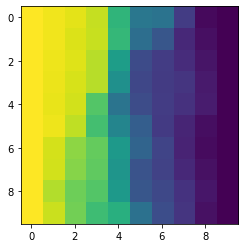

In [5]:
plt.imshow(fp.utils.HeadFile("workspace/test_mf6_pst.hds").get_data((0,0))[0])

Setup PEST

In [6]:
import pyemu

In [7]:
sim = fp.mf6.MFSimulation.load(sim_ws=workspace)
m = sim.get_model("test_mf6_pst")

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package npf...
    loading package chd...
    loading package obs...
  loading ims package test_mf6_pst...


Get spatialReference

In [8]:
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(workspace, "{}.nam".format(model_name)),
        delr=m.dis.delr.array, delc=m.dis.delc.array)
sr

   could not remove start_datetime


xul:0; yul:100; rotation:0; proj4_str:None; units:meters; lenuni:2; length_multiplier:1.0

In [10]:
#empty pest object
template_ws = "template"
pf = pyemu.prototypes.PstFrom(original_d=workspace, new_d=template_ws,
                 remove_existing=True,
                 longnames=True, spatial_reference=sr,
                 zero_based=False)

2020-06-23 17:51:20.160228 starting: opening PstFrom.log for logging
2020-06-23 17:51:20.160228 starting PstFrom process
2020-06-23 17:51:20.160228 starting: setting up dirs
2020-06-23 17:51:20.160228 starting: removing existing new_d 'template'
2020-06-23 17:51:20.191477 finished: removing existing new_d 'template' took: 0:00:00.031249
2020-06-23 17:51:20.191477 starting: copying original_d 'workspace' to new_d 'template'
2020-06-23 17:51:20.601944 finished: copying original_d 'workspace' to new_d 'template' took: 0:00:00.410467
2020-06-23 17:51:20.617570 finished: setting up dirs took: 0:00:00.457342


In [11]:
#add observation
df = pd.read_csv(os.path.join(template_ws,"heads.csv"),index_col=0)

hds_df = pf.add_observations("heads.csv",insfile="heads.csv.ins",index_cols="time",
                use_cols=list(df.columns.values),prefix="hds",obsgp=False)
pf.obs_dfs[0].iloc[1:5,2]=0.5 # change weight

2020-06-23 17:51:22.671249 starting: adding observations from tabular output file
2020-06-23 17:51:22.671249 starting: reading list template\heads.csv
2020-06-23 17:51:22.671249 finished: reading list template\heads.csv took: 0:00:00
2020-06-23 17:51:22.686860 starting: building insfile for tabular output file heads.csv
2020-06-23 17:51:22.702506 finished: building insfile for tabular output file heads.csv took: 0:00:00.015646
2020-06-23 17:51:22.702506 starting: adding observation from instruction file 'template\heads.csv.ins'
2020-06-23 17:51:22.722640 finished: adding observation from instruction file 'template\heads.csv.ins' took: 0:00:00.020134
2020-06-23 17:51:22.722640 finished: adding observations from tabular output file took: 0:00:00.051391


In [12]:
pf.build_pst("mf6_test_1.pst")

noptmax:30, npar_adj:0, nnz_obs:64


spatial variogram


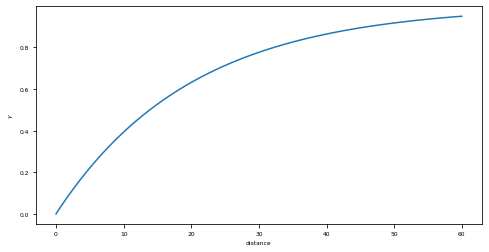

In [13]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=20)
grid_gs = pyemu.geostats.GeoStruct(variograms=v, transform='log')

fig = plt.figure(figsize=(8,4))
grid_gs.plot()
print("spatial variogram")

In [14]:
hk_arr_files = [f for f in os.listdir(template_ws) if "k" in f and f.endswith(".txt")]
hk_arr_files

['k.txt']

In [15]:
# reinitialize the k array (homogeneous)
k = 1e-4*np.ones([nrow,ncol])
filnm = "k.txt"
np.savetxt(os.path.join(template_ws,filnm),k)

In [16]:
pf.add_parameters(filenames="k.txt",par_type="grid",
                   par_name_base="hk",pargp="hk",zone_array=np.ones([nrow,ncol]),
                   upper_bound=10.,lower_bound=0.1,ult_ubound=100,ult_lbound=0.01,geostruct=grid_gs)

2020-06-23 17:51:24.175623 starting: adding grid type multiplier style parameters for file(s) ['k.txt']
2020-06-23 17:51:24.175623 starting: loading array template\k.txt
2020-06-23 17:51:24.191179 finished: loading array template\k.txt took: 0:00:00.015556
2020-06-23 17:51:24.191179 loaded array 'k.txt' of shape (10, 10)
2020-06-23 17:51:24.206805 starting: writing array-based template file 'hk_inst0_grid.csv.tpl'
2020-06-23 17:51:24.206805 starting: writing template file hk_inst0_grid.csv.tpl for ['hk_inst:0']
2020-06-23 17:51:24.238055 finished: writing template file hk_inst0_grid.csv.tpl for ['hk_inst:0'] took: 0:00:00.031250
2020-06-23 17:51:24.238055 finished: writing array-based template file 'hk_inst0_grid.csv.tpl' took: 0:00:00.031250
2020-06-23 17:51:24.244574 starting: adding parameters for file(s) ['k.txt']


In [17]:
#for i in range(len(pf.par_dfs)):
#    pf.par_dfs[i].loc[:,"pargp"]="hk_mul"

In [18]:
pst = pf.build_pst("mf6_test_1.pst")

noptmax:30, npar_adj:100, nnz_obs:64


In [19]:
# only execute this block once!
pf.mod_sys_cmds.append("..\..\..\exe\mf6")
pst = pf.build_pst()

noptmax:30, npar_adj:100, nnz_obs:64
2020-06-23 17:51:24.910538 forward_run line:pyemu.os_utils.run(r'..\..\..\exe\mf6')



noptmax:30, npar_adj:100, nnz_obs:64
2020-06-23 17:51:26.834657 WARNING: sys_cmd 'pyemu.os_utils.run(r'..\..\..\exe\mf6')
' already in sys cmds, skipping...
2020-06-23 17:51:26.856786 starting: building prior covariance matrix
2020-06-23 17:51:26.872419 saving prior covariance matrix to file template\mf6_test_1.prior.cov
2020-06-23 17:51:26.919285 finished: building prior covariance matrix took: 0:00:00.062499


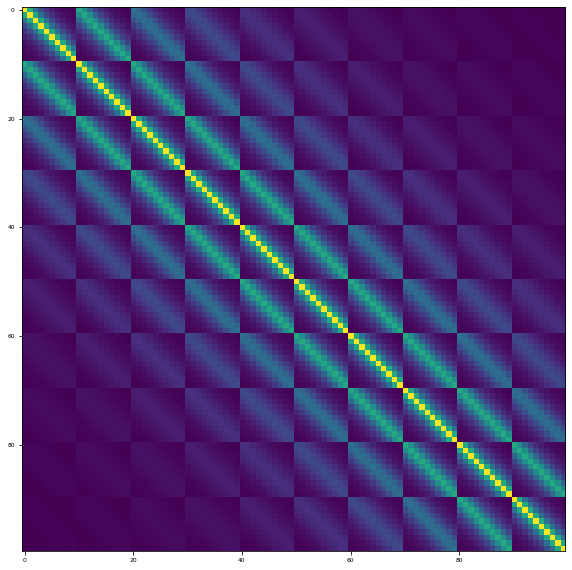

In [20]:
pst = pf.build_pst('mf6_test_1.pst')
cov = pf.build_prior()
x = cov.x.copy()
x[x==0.0] = np.NaN
fig,ax = plt.subplots(1,1,figsize=(10,10))
g = ax.imshow(x)

In [ ]:
t_d = "template"
m_d = "master_glm"

pst.control_data.noptmax = -1
pst.write(os.path.join(t_d,"mf6_test_1.pst"))


pyemu.os_utils.start_workers(t_d,"../ipestpp-glm.exe","mf6_test_1.pst",num_workers=4,worker_root=".",
                           master_dir=m_d)

noptmax:-1, npar_adj:100, nnz_obs:64
